In [3]:
import itertools

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from skimage.filters import threshold_mean

from task_4_core.hopfield import Hopfield 

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
def binarize(threshold, data):
    return np.where(data > threshold, 1, -1)

In [4]:
def get_input(threshold, class_count):
    train_index = np.where(train_labels < class_count)
    train_images_binarized = binarize(threshold, train_images).reshape(train_images.shape[0], train_images.shape[1] * train_images.shape[2])
    
    test_index = np.where(test_labels < class_count)
    test_images_binarized = binarize(threshold, test_images).reshape(test_images.shape[0], test_images.shape[1] * test_images.shape[2])

    return (train_images_binarized[train_index], train_labels[train_index]), (test_images_binarized[test_index], test_labels[test_index])

In [5]:
def hopfield_train_test(train_data, test_data, iterations, threshold=0, learning_rule='hebb', energy_function='classic', update_function='sync', async_iterations = 100):
    # pick first instances of eash class as a reference
    (train, train_labels) = train_data
    classes = np.unique(train_labels)
    references = list(map(lambda n: train[np.where(train_labels == n)[0][0]], classes))

    # put them in network memory and train the network on them
    hopfield = Hopfield((28, 28))
    hopfield.train_weights(references, learning_rule)

    (test, test_labels) = test_data
    predictions = []

    # for each test:
    for i in range(test.shape[0]):
        # example use the inference n times
        result = hopfield.predict([test[i]], iterations, threshold, energy_function, update_function, async_iterations)[-1]
        
        # then pick the label of the reference that has the least different elements - this is the classification result
        reference_similarities = list(map(lambda ref: np.count_nonzero(ref==result), references))
        label = reference_similarities.index(max(reference_similarities))
        predictions.append(label)

    # evaluate the metrics based on the results
    predictions = np.array(predictions)
    
    accuracy = accuracy_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    precision = precision_score(test_labels, predictions, average='macro')

    return hopfield, (accuracy, f1, recall, precision)

In [6]:
for class_count in range(2, 10):
    train, test = get_input(1, class_count)
    print(f"Classes: {class_count}")

    for iterations in range(1, 2, 1):
        model, (accuracy, f1, recall, precision) = hopfield_train_test(train, test, 10, 100, 'hebb', 'classic', 'sync')
        print(f"With {iterations} iterations: Accuracy: {accuracy}, F1: {f1}, Recall: {recall}, Precision: {precision}")

    print('\n\n\n')

    for iterations in range(1, 2, 1):
        model, (accuracy, f1, recall, precision) = hopfield_train_test(train, test, 10, 100, 'hebb', 'classic', 'async', async_iterations = 100)
        print(f"With {iterations} iterations: Accuracy: {accuracy}, F1: {f1}, Recall: {recall}, Precision: {precision}")

    print('\n\n\n')

Classes: 2
With 1 iterations: Accuracy: 0.9867612293144208, F1: 0.9866635558806467, Recall: 0.9857839611615571, Precision: 0.9878479840085808




KeyboardInterrupt: 

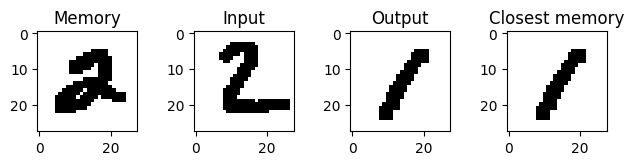

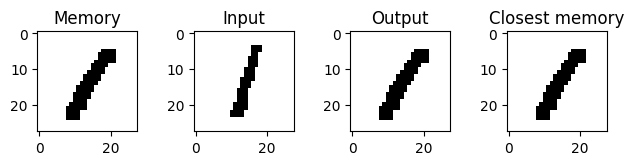

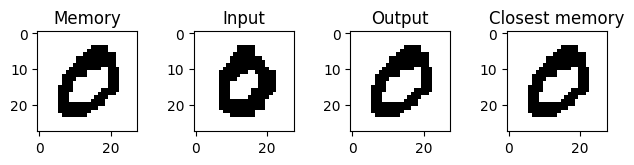

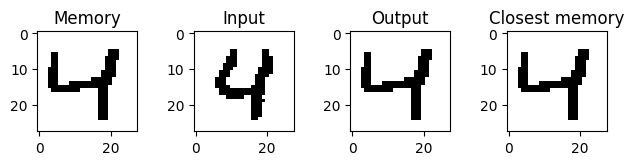

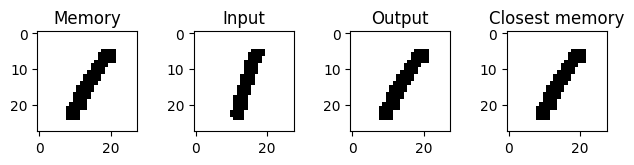

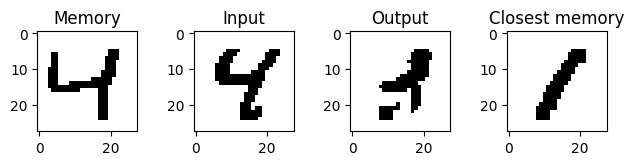

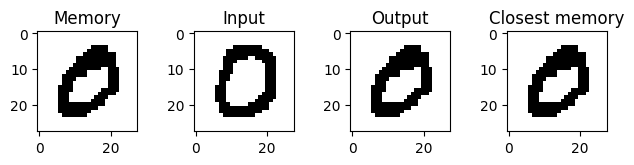

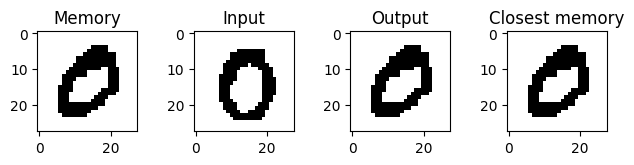

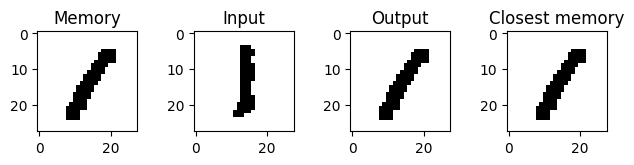

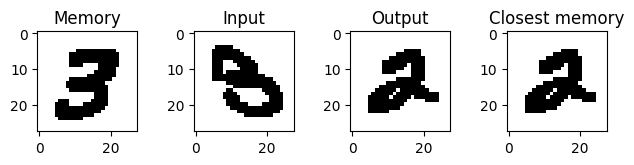

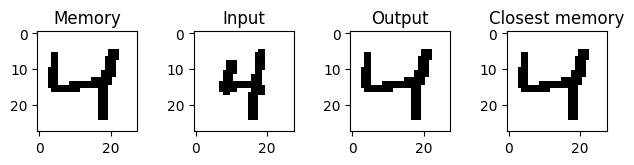

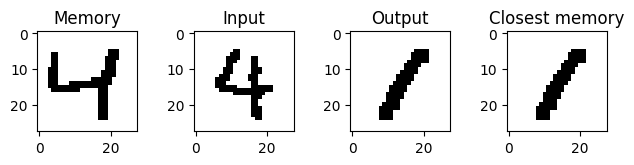

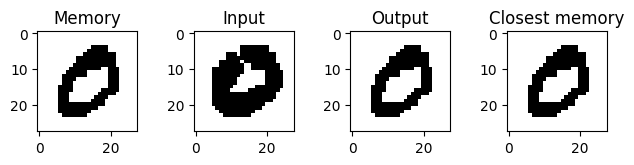

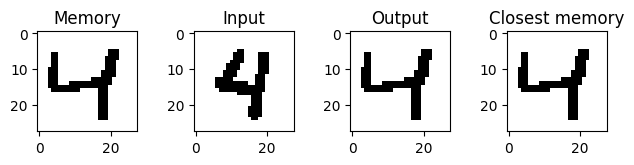

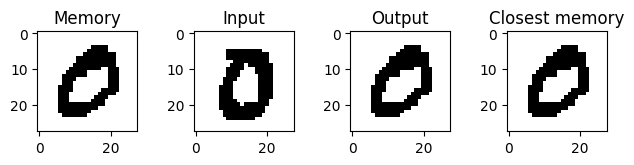

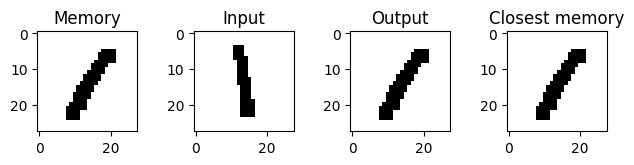

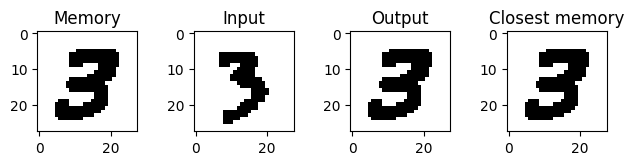

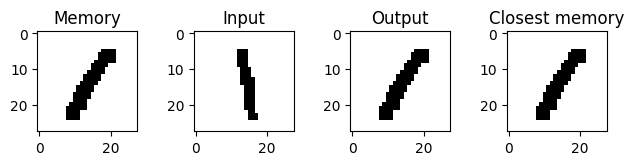

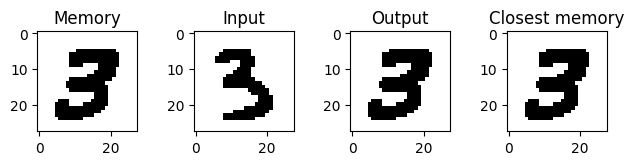

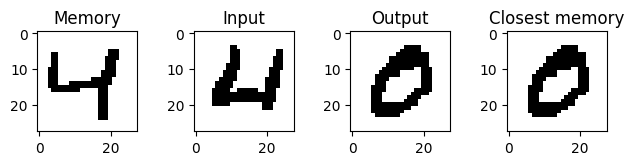

In [10]:
classes_count = 10

train, test = get_input(1, classes_count)
classes = list(np.unique(train[1]))
references = list(map(lambda n: train[0][np.where(train[1] == n)[0]][0], classes))

model = Hopfield((28, 28))
model.train_weights(references, 'demircigil')

for i in range(20):
    label = test[1][i]
    image = test[0][i]
    predicted = model.predict([image], 1, threshold=0, energy_function='exp', update_function='demircigil')[0]

    reference_similarities = list(map(lambda ref: np.count_nonzero(ref == predicted), references))
    prediction = reference_similarities.index(max(reference_similarities))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
    fig.tight_layout(pad=1.0)

    ax1.imshow(references[label].reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax1.set_title("Memory")
    ax2.imshow(image.reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax2.set_title("Input")
    ax3.imshow(predicted.reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax3.set_title("Output")
    ax4.imshow(references[prediction].reshape(28, 28), cmap='Greys',  interpolation='nearest')
    ax4.set_title("Closest memory")

    plt.show()